# Amazon Bin Image Dataset EDA

In this notebook, an exploratory EDA of the Amazon Bin Image Dataset is performed.

Information on the dataset can be found at: https://github.com/awslabs/open-data-docs/tree/main/docs/aft-vbi-pds.

In short, the dataset contains 500,000 bin JPEG images and corresponding JSON metadata files describing items. There is a JSON file for each image.

The images are snapshots of the contents of bins within Amazon distribution centers. Each bin contains a certain number of items. The JSON metadata file for each image contains information about the products in the bin, and the count of the number of items. 

Due to the large size of the dataset, to the cost/time constraints for this project, a randomly selected subsample of 66,667 images will be extracted from the full dataset.

The goal of this EDA is to characterize the subsample, create labels for machine learning, and perform a train, validation, test split.

## Setup S3 bucket with the images

In [1]:
import boto3

In [2]:
# subsampled dataset
client = boto3.client('s3')
response = client.create_bucket(
    ACL='private',
    Bucket='amazon-bin-images-sub',
)

## Import useful module for the rest of the analysis

In [1]:
import os
import sys
import numpy as np
import pandas as pd
from PIL import Image
from eda_utils import *
import boto3

import matplotlib as mpl
from matplotlib import pyplot as plt

## Extract a random subsample of 66,667 images from the first 500,000 images

This piece of code runs only locally and only operates on the ids.

In [2]:
image_ids_sel_path = './image_ids_sel.csv'
n_full = 500000
n_sel = 66667
if not os.path.exists(image_ids_sel_path):
    image_ids_sel = generate_image_ids_sel(image_ids_sel_path,n_full,n_sel)
else:
    image_ids_sel = load_image_ids_sel(image_ids_sel_path)

Loaded random subsample of 66667 images.


In [3]:
image_ids_sel

,id
0,2
1,10
2,20
3,26
4,34
...,...
66662,499963
66663,499973
66664,499977
66665,499980


## Move images public S3 bucket to private S3 bucket

Run data transfer only once since it takes > 1 h.

In [4]:
s3source = 'aft-vbi-pds'
s3source_prefix = 'bin-images'
s3dest = 'amazon-bin-images-sub'
s3dest_prefix = ''
tr_img = image_ids_sel.loc[:,'id'].apply(lambda x: transfer_images(x,s3source,s3source_prefix,s3dest,s3dest_prefix))

## Move metadata from public S3 bucket to private S3 bucket, and retrieve item counts per image

Run data transfer only once since it takes > 1 h.

In [5]:
s3source = 'aft-vbi-pds'
s3source_prefix = 'metadata'
s3dest = 'amazon-bin-images-sub'
s3dest_prefix = ''
image_ids_sel.loc[:,'count'] = image_ids_sel.loc[:,'id']\
    .apply(lambda x: transfer_metadata(x,s3source,s3source_prefix,s3dest,s3dest_prefix))

In [6]:
image_ids_sel_wcount_path = './image_ids_sel_wcount.csv'
image_ids_sel.to_csv(image_ids_sel_wcount_path,index=False)

## Load list of images with metadata

Load list of selected images with counts if it exists, otherwise generate it.

In [4]:
image_ids_sel_wcount_path = './image_ids_sel_wcount.csv'
if not os.path.exists(image_ids_sel_wcount_path):
    s3bucket = 'amazon-bin-images-sub'
    s3prefix = ''
    image_ids_sel.loc[:,'count'] = image_ids_sel.loc[:,'id']\
        .apply(lambda x: get_image_item_count(get_image_item_count(x,s3bucket,s3prefix)))
    image_ids_sel.to_csv(image_ids_sel_wcount_path,index=False)
else:
    image_ids_sel = load_image_ids_sel(image_ids_sel_wcount_path)

Loaded random subsample of 66667 images.


In [5]:
image_ids_sel

,id,count
0,2,17
1,10,4
2,20,14
3,26,6
4,34,2
...,...,...
66662,499963,3
66663,499973,7
66664,499977,7
66665,499980,2


## Inspect distribution of item counts

In [6]:
image_ids_sel.describe()

,id,count
count,66667.000000,66667.000000
mean,248856.521082,5.118289
std,144220.668095,4.729124
min,2.000000,0.000000
25%,123780.000000,3.000000
50%,248463.000000,4.000000
75%,372942.000000,6.000000
max,499993.000000,173.000000


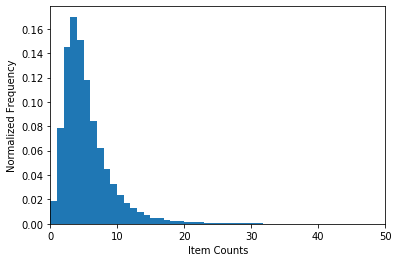

In [7]:
nbins = image_ids_sel['count'].max()+1
plt.xlim(0,50)
plt.xlabel('Item Counts')
plt.ylabel('Normalized Frequency')
count_hist = plt.hist(image_ids_sel['count'],bins=nbins,density=True)

## Item count analysis and label creation for ML

The analysis above shows that 75% of the bins have <= 6 items in them. The remaining 25% of the bins in the dataset have item counts > 6, up to 173. 

In this project, the goal is to identify the number of items in each image with a computer vision model. Since the dataset is dominated by objects with low item count, it will be difficult to train the model to recognize the most rare number counts. The published baseline solution to the problem proposed at https://github.com/silverbottlep/abid_challenge proposes a simplified version of the problem in which only the subset of images with 0-5 items are considered for the problem. 

To better compare to the baseline model, the same approach will be followed here. The label for each image is defined as:

- Count < 6: Label = Count 

- Count >= 6: Label = 6

Only images with Count < 6 will be included in the training, validation, and testing sets. This choice defines a supervised learning classification task with 6 classes (item counts 0-5).

Model architecture is reported below.

![title](../ml_model/images/model_architecture.png)

In [8]:
image_ids_sel_wcount_wlabel_path = './image_ids_sel_wcount_wlabel.csv'
if not os.path.exists(image_ids_sel_wcount_wlabel_path):
    thr = 6
    image_ids_sel.loc[:,'label'] = image_ids_sel.loc[:,'count'].apply(lambda x: generate_labels(x,thr))
    image_ids_sel = image_ids_sel[image_ids_sel['count'] < thr]
    image_ids_sel.reset_index(drop=True,inplace=True)
    image_ids_sel.to_csv(image_ids_sel_wcount_wlabel_path,index=False)
else:
    image_ids_sel = load_image_ids_sel(image_ids_sel_wcount_wlabel_path)

In [9]:
image_ids_sel

,id,count,label
0,10,4,4
1,34,2,2
2,37,3,3
3,38,2,2
4,60,3,3
...,...,...,...
45108,499959,4,4
45109,499962,3,3
45110,499963,3,3
45111,499980,2,2


## Final dataset

The final dataset contains 45113 images with classe labels 0-5.

## Analysis of the label distribution

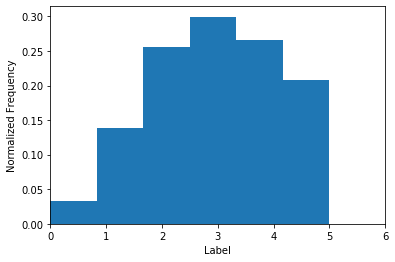

In [10]:
nbins = image_ids_sel['label'].max()+1
plt.xlim(0,6)
plt.xlabel('Label')
plt.ylabel('Normalized Frequency')
count_hist = plt.hist(image_ids_sel['label'],bins=nbins,density=True)

## Number of images by class label

As shown in the histogram above class balancing is not perfect, but each class receives > 1000 examples (see below). 

In [11]:
image_ids_sel.groupby(by=['label']).agg('count')['id']

label
0     1241
1     5184
2     9625
3    11260
4     9979
5     7824
Name: id, dtype: int64

## Visual image inspection

Image pre-processing will be included in the script that performs training. 

Here, we limit ourselves to inspect one of the images and verify that it can be retrieved from S3.

In [12]:
s3bucket = 'amazon-bin-images-sub'
s3prefix = ''
idd1 = 2 
idd2 = 10
img1 = get_image(idd1,s3bucket,s3prefix)
img2 = get_image(idd2,s3bucket,s3prefix)

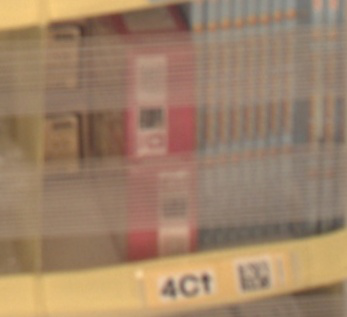

In [13]:
img1

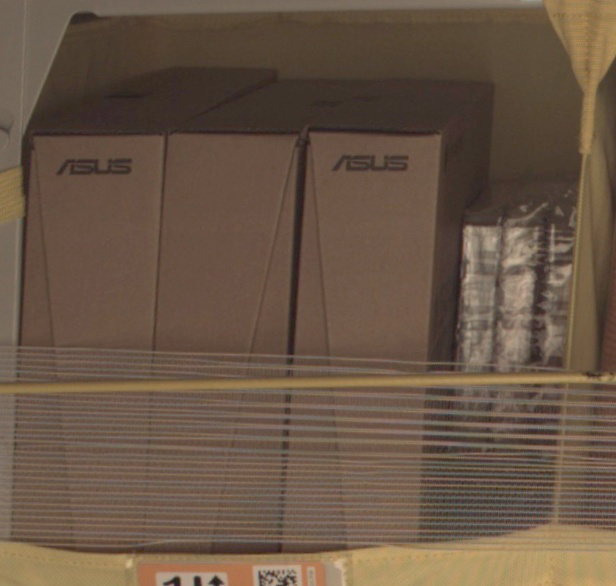

In [14]:
img2

### Counting the number of objects in these images is hard even for humans!




## Inspect image size

Image size is not fixed, it will need to be standardized before the model is applied.

In [15]:
img_data1 = np.asarray(img1)
img_data2 = np.asarray(img2)
print(f'Image {idd1} shape:',img_data1.shape)
print(f'Image {idd2} shape:',img_data2.shape)

Image 2 shape: (317, 347, 3)
Image 10 shape: (586, 616, 3)


## Inspect pixel values

The images a JPEG with the usual RGB channels with pixel values from 0 to 255.

In [16]:
print(f'Image {idd1} min pixel value:',img_data1.min())
print(f'Image {idd1} max pixel value:',img_data1.max())
print(f'Image {idd2} min pixel value:',img_data2.min())
print(f'Image {idd2} max pixel value:',img_data2.max())

Image 2 min pixel value: 42
Image 2 max pixel value: 250
Image 10 min pixel value: 14
Image 10 max pixel value: 212


## Create train, validation, test split

Here we perform an 80:10:10 random split 

In [17]:
split = (0.8,0.1,0.1)
train_df,val_df,test_df = train_val_test_split(image_ids_sel,split)
train_df.to_csv('./train.csv',index=False)
val_df.to_csv('./validation.csv',index=False)
test_df.to_csv('./test.csv',index=False)

## Verify that the label distributions are similar in train, validation and test sets

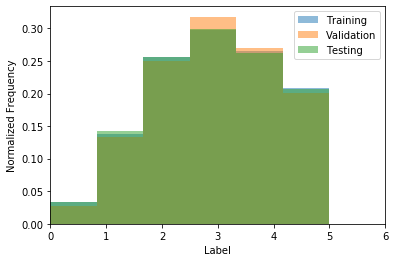

In [18]:
nbins = image_ids_sel['label'].max()+1
plt.xlim(0,6)
plt.xlabel('Label')
plt.ylabel('Normalized Frequency')
count_hist_train = plt.hist(train_df['label'],bins=nbins,density=True,alpha=0.5,label='Training')
count_hist_val = plt.hist(val_df['label'],bins=nbins,density=True,alpha=0.5,label='Validation')
count_hist_test = plt.hist(test_df['label'],bins=nbins,density=True,alpha=0.5,label='Testing')
plt.legend(loc=1)

## Transfer to subsample S3 bucket

In [19]:
!aws s3 cp ./train.csv s3://amazon-bin-images-sub/

upload: ./train.csv to s3://amazon-bin-images-sub/train.csv       


In [20]:
!aws s3 cp ./validation.csv s3://amazon-bin-images-sub/

upload: ./validation.csv to s3://amazon-bin-images-sub/validation.csv


In [21]:
!aws s3 cp ./test.csv s3://amazon-bin-images-sub/

upload: ./test.csv to s3://amazon-bin-images-sub/test.csv         
